In [1]:
from __future__ import division, print_function, absolute_import
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib notebook


# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Training Params
num_steps = 10000
batch_size = 128
learning_rate = 0.0002

# Network Params
image_dim = 784 # 28*28 pixels
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 100 # Noise data points

# Xavier Initialization
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

# Store layers weight & bias
# Dictionary 형태로 Weight & Bias를 저장하고 있음
# Generator : 100 -> 256 -> 784
# Generator : 784 -> 256 -> 1
weights = {
    'gen_hidden1': tf.Variable(glorot_init([noise_dim, gen_hidden_dim])),
    'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim])),
    'disc_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden_dim])),
    'disc_out': tf.Variable(glorot_init([disc_hidden_dim, 1])),
}
biases = {
    'gen_hidden1': tf.Variable(tf.zeros([gen_hidden_dim])),
    'gen_out': tf.Variable(tf.zeros([image_dim])),
    'disc_hidden1': tf.Variable(tf.zeros([disc_hidden_dim])),
    'disc_out': tf.Variable(tf.zeros([1])),
}

# Generator를 생성하는 함수를 정의합니다.
# Inputs:
#   X : 인풋 Noise
# Output:
#   generated_mnist_image : 생성된 MNIST 이미지
def generator(x):
    hidden_layer = tf.matmul(x, weights['gen_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['gen_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['gen_out'])
    out_layer = tf.add(out_layer, biases['gen_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer


# Discriminator를 생성하는 함수를 정의합니다.
# Inputs:
#   X : 인풋 이미지
# Output:
#   Discriminator가 판단한 True(1) or Fake(0)
def discriminator(x):
    hidden_layer = tf.matmul(x, weights['disc_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['disc_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['disc_out'])
    out_layer = tf.add(out_layer, biases['disc_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

# Build Networks
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_input')

# Build Generator Network
gen_sample = generator(gen_input)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(disc_input) # D(x)
disc_fake = discriminator(gen_sample) # D(G(z))

# Build Loss Function
# gen의 loss는 disc_fake
gen_loss = -tf.reduce_mean(tf.log(disc_fake)) # log(D(G(z))
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake)) # log(D(x)) + log(1-D(G(z)))

# Build Adam Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = [weights['gen_hidden1'], weights['gen_out'],
            biases['gen_hidden1'], biases['gen_out']]
# Discriminator Network Variables
disc_vars = [weights['disc_hidden1'], weights['disc_out'],
            biases['disc_hidden1'], biases['disc_out']]

# Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from t

Step 1: Generator Loss: 0.494056, Discriminator Loss: 1.593605
Step 1000: Generator Loss: 4.008462, Discriminator Loss: 0.048639
Step 2000: Generator Loss: 4.503149, Discriminator Loss: 0.072058
Step 3000: Generator Loss: 5.651710, Discriminator Loss: 0.006933
Step 4000: Generator Loss: 3.511778, Discriminator Loss: 0.081388
Step 5000: Generator Loss: 3.818022, Discriminator Loss: 0.092983
Step 6000: Generator Loss: 5.280301, Discriminator Loss: 0.076793
Step 7000: Generator Loss: 4.517143, Discriminator Loss: 0.080880
Step 8000: Generator Loss: 4.345651, Discriminator Loss: 0.137829
Step 9000: Generator Loss: 3.871009, Discriminator Loss: 0.116268
Step 10000: Generator Loss: 4.245384, Discriminator Loss: 0.146600


<IPython.core.display.Javascript object>


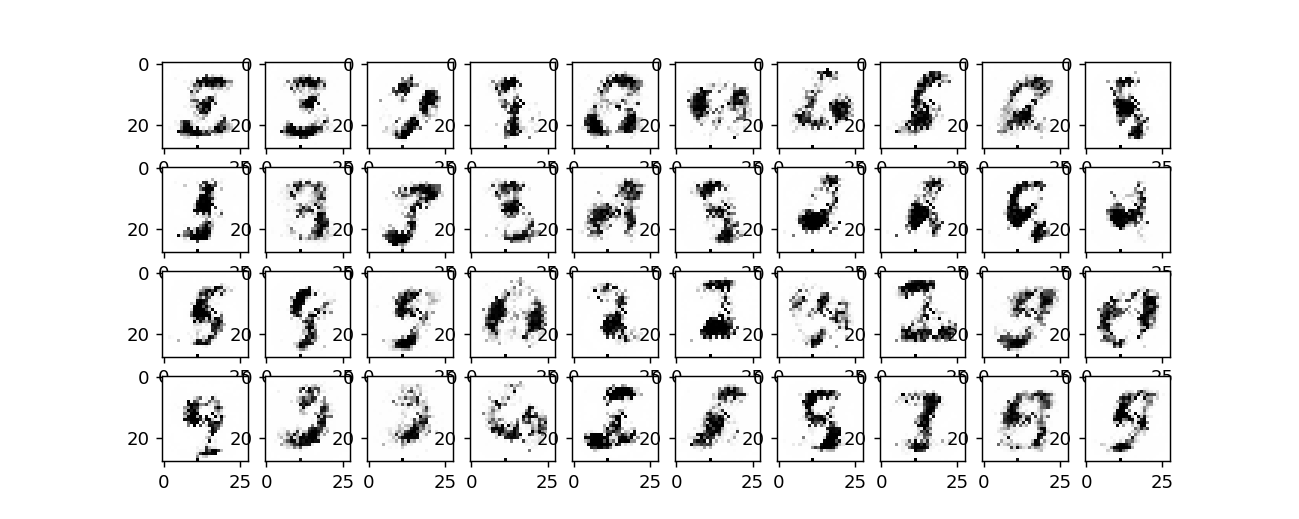

In [2]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, _ = mnist.train.next_batch(batch_size)
        # Generate noise to feed to the generator
        # -1~1 사이의 size 만큼 uniform 분포에서 샘플링
        z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

        # Train
        feed_dict = {disc_input: batch_x, gen_input: z}
        _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                                feed_dict=feed_dict)
        if i % 1000 == 0 or i == 1:
            print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
            
    # Generate images from noise, using the generator network.
    f, a = plt.subplots(4, 10, figsize=(10, 4))
    for i in range(10):
        # Noise input.
        z = np.random.uniform(-1., 1., size=[4, noise_dim])
        g = sess.run([gen_sample], feed_dict={gen_input: z})
        g = np.reshape(g, newshape=(4, 28, 28, 1))
        # Reverse colours for better display
        g = -1 * (g - 1)
        for j in range(4):
            # Generate image from noise. Extend to 3 channels for matplot figure.
            img = np.reshape(np.repeat(g[j][:, :, np.newaxis], 3, axis=2),
                             newshape=(28, 28, 3))
            a[j][i].imshow(img)

    f.show()
    # plt.savefig("GAN.png")
    plt.draw()
#     plt.waitforbuttonpress()